In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import os
import time

import my_funcs as my

Initial test runs

In [3]:
Cs = [1,10,100] #condition numbers on the random covariance
Ns = [2,11,21,31,41,51] #number of particles to use
D = 50 #dimension of the target
num_iter = 30000 #number of iterations
num_runs = 1 #number of runs 
eta = 10e-3 #learning rate
standard_normal = torch.distributions.MultivariateNormal(torch.zeros(D),torch.eye(D)) #q0
#optimizer = my.SGD(eta = 1e-3,gamma = 0.9)
optimizer = my.AdaGrad(eta = eta, alpha = 0.9)

In [4]:
N = Ns[-1]
C = Cs[-1]

In [5]:
target_mean = standard_normal.sample()
target_covariance = my.random_covariance(D,Lmin = 0.1, Lmax = 0.1*C)
p = torch.distributions.MultivariateNormal(target_mean,target_covariance)
x0 = standard_normal.sample([N])

t0 = time.time()
x_gpf = my.gpf(x0,p,num_iter = num_iter,eta1 = eta, eta2 = eta, history = True)
t1 = time.time()
x_lin = my.svgd(x0,p,num_iter = num_iter,kernel = 'linear',optimizer = optimizer, history = True)
t2 = time.time()

In [6]:
print('runtime gpf:{:.2f}s'.format(t1 - t0))
print('runtime svgd:{:.2f}s'.format(t2 - t1))

runtime gpf:91.06s
runtime svgd:27.24s


In [7]:
#calculate the covariance of the particles at each step
cov_gpf = torch.stack([my.estimate_cov(x) for x in x_gpf])
cov_svgd = torch.stack([my.estimate_cov(x) for x in x_lin])

In [8]:
#calculate the l2 norm of the update step at each step
gpf_l2step = torch.linalg.norm(x_gpf[1:]-x_gpf[:-1],dim=(1,2))
svgd_l2step = torch.linalg.norm(x_lin[1:]-x_lin[:-1],dim=(1,2))

In [9]:
#calculate the rmse between the mean and the target mean
gpf_mean_rmse = torch.sqrt(torch.mean((torch.mean(x_gpf,1)-p.mean)**2,1))
svgd_mean_rmse = torch.sqrt(torch.mean((torch.mean(x_lin,1)-p.mean)**2,1))
#calculate the rmse between the covariance and the target covariance
gpf_cov_rmse =[torch.sqrt(torch.mean((c - p.covariance_matrix)**2)) for c in cov_gpf]
svgd_cov_rmse = [torch.sqrt(torch.mean((c - p.covariance_matrix)**2)) for c in cov_svgd]
#calculate the trace error between the covariance and the target covariance
gpf_cov_tr = [torch.abs(torch.trace(c - p.covariance_matrix)) for c in cov_gpf]
svgd_cov_tr = [torch.abs(torch.trace(c - p.covariance_matrix)) for c in cov_svgd]

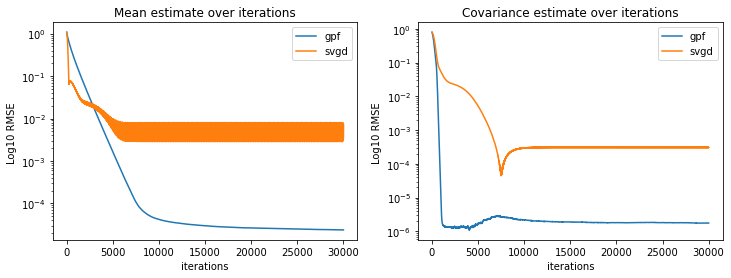

In [10]:
fig,axs = plt.subplots(1,2,figsize=(12,4))

axs[0].semilogy(gpf_mean_rmse,label='gpf')
axs[0].semilogy(svgd_mean_rmse,label='svgd')
axs[0].set_title('Mean estimate over iterations')
axs[0].set_xlabel('iterations')
axs[0].set_ylabel('Log10 RMSE ')
axs[0].legend()
axs[1].semilogy(gpf_cov_rmse,label='gpf')
axs[1].semilogy(svgd_cov_rmse,label='svgd')
axs[1].set_title('Covariance estimate over iterations')
axs[1].set_xlabel('iterations')
axs[1].set_ylabel('Log10 RMSE ')
axs[1].legend()
plt.show()

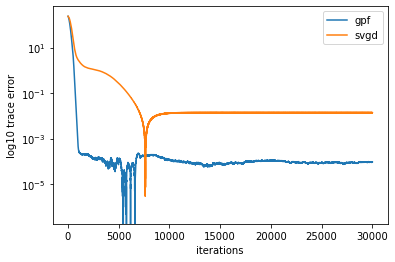

In [11]:
plt.semilogy(gpf_cov_tr,label='gpf')
plt.semilogy(svgd_cov_tr,label='svgd')
plt.legend()
plt.xlabel('iterations')
plt.ylabel('log10 trace error')
plt.show()

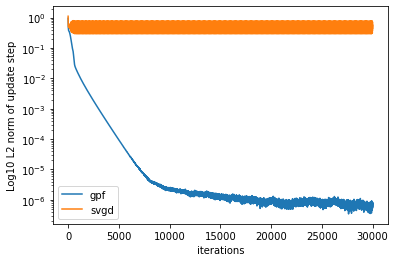

In [12]:
plt.semilogy(gpf_l2step,label='gpf')
plt.semilogy(svgd_l2step,label='svgd')
plt.legend()
plt.xlabel('iterations')
plt.ylabel('Log10 L2 norm of update step')
plt.show()

In [ ]:
Ns = [2,11,21,31,41,51,61]

Grid single runs

In [16]:
Cs = [1,10,100] #condition numbers on the random covariance
Ns = [2,11,21,31,41,51,61]#number of particles to use
D = 50 #dimension of the target
num_iter = 15000 #number of iterations
num_runs = 1 #number of runs 
eta = 5e-3 #learning rate

standard_normal = torch.distributions.MultivariateNormal(torch.zeros(D),torch.eye(D)) #q0

labels = ['gpf','svgd']

names = ['gpf','svgd_SGD_0.9','svgd_AdaGrad_0.9','svgd_AdaGrad_0.5']

In [22]:
a,b,c = names[0].split('_')

ValueError: not enough values to unpack (expected 3, got 1)

In [5]:
file_list = ['x0','target','x_gpf','x_svgd_SGD_0.9','x_svgd_AdaGrad_0.9','x_svgd_AdaGrad_0.5']

In [18]:
run = 0

data_path = os.path.join(os.getcwd(), 'data_iter_{}_eta_{}_D_{}'.format(num_iter,eta,D))
if not os.path.exists(data_path):
    os.mkdir(data_path)
    
for i,C in enumerate(Cs):
    for j,N in enumerate(Ns):

        run_path = os.path.join(data_path,'run_{}_C_{}_N_{}'.format(run,C,N))

        if not os.path.exists(run_path):
            os.mkdir(run_path)
        elif os.listdir(run_path) != sorted(file_list):
            pass
        else:
            continue

        p = torch.distributions.MultivariateNormal(
            standard_normal.sample(),my.random_covariance(D,Lmin = 0.1, Lmax = 0.1*C))
        x0 = standard_normal.sample([N])
        
        torch.save(p,os.path.join(run_path,'target'))
        torch.save(x0,os.path.join(run_path,'x0'))
        
        for name in names:
            if name == 'gpf':
                x = my.gpf(x0,p,num_iter = num_iter,eta1 = eta, eta2 = eta)
                torch.save(x,os.path.join(run_path,'x_{}'.format(name)))
                
            else:
                label,alg,para = name.split('_')

                if alg == 'SGD':
                    optimizer = my.SGD(eta,gamma = float(para))
                elif alg == 'AdaGrad':
                    optimizer = my.AdaGrad(eta,alpha = float(para))
                else:
                    print('Please choose from AdaGrad or SGD')

                x = my.svgd(x0,p,num_iter = num_iter,kernel = 'linear',optimizer = optimizer)
                torch.save(x,os.path.join(run_path,'x_{}'.format(name)))
        

In [23]:
mean_rmse = torch.zeros((len(Cs),len(Ns),len(optimizers)+1))
cov_rmse = torch.zeros((len(Cs),len(Ns),len(optimizers)+1))
trace_err = torch.zeros((len(Cs),len(Ns),len(optimizers)+1))

for i,C in enumerate(Cs):
    for j,N in enumerate(Ns):
        run_path = os.path.join(data_path,'run_{}_C_{}_N_{}'.format(run,C,N))
        p = torch.load(os.path.join(run_path,'target'))
        for k,name in enumerate(names):
            x = torch.load(os.path.join(run_path,'x_{}'.format(name)))
            mean_rmse[i,j,k],cov_rmse[i,j,k],trace_err[i,j,k] = my.evaluate(x,p)


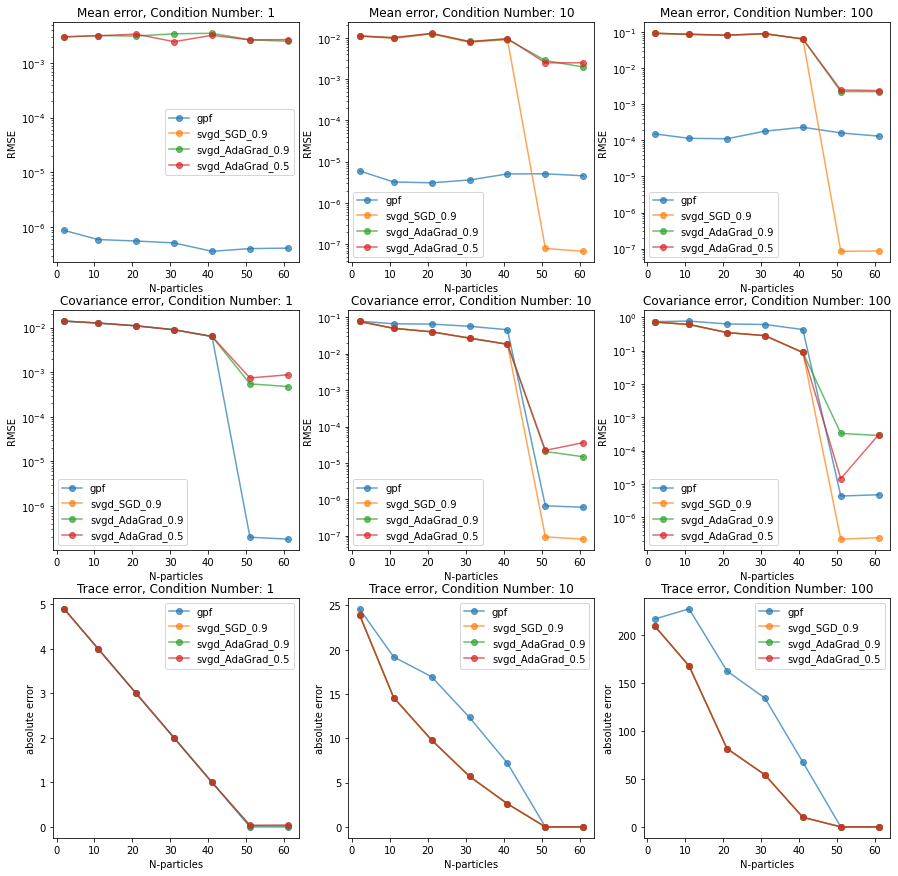

In [24]:
fig,axs = plt.subplots(3,len(Cs),figsize=(15,15))
for i,C in enumerate(Cs):
    plt.sca(axs[0,i])
    for j in range(len(names)):
        plt.semilogy(Ns,mean_rmse[i,:,j],'-o',label=names[j],alpha=0.7)
    plt.legend()
    plt.xlabel('N-particles')
    plt.ylabel('RMSE')
    plt.title('Mean error, Condition Number: {}'.format(C))
    
    plt.sca(axs[1,i])
    for j in range(len(names)):
        plt.semilogy(Ns,cov_rmse[i,:,j],'-o',label=names[j],alpha=0.7)
    plt.legend()
    plt.xlabel('N-particles')
    plt.ylabel('RMSE')
    plt.title('Covariance error, Condition Number: {}'.format(C))
    
    plt.sca(axs[2,i])
    for j in range(len(names)):
        plt.plot(Ns,trace_err[i,:,j],'-o',label=names[j],alpha=0.7)
    plt.legend()
    plt.xlabel('N-particles')
    plt.ylabel('absolute error')
    plt.title('Trace error, Condition Number: {}'.format(C))

Grid 10 runs

In [4]:
Cs = [1,10,100] #condition numbers on the random covariance
 
Ns = [2,11,21,31,41,51]#number of particles to use
D = 50 #dimension of the target
num_iter = 30000 #number of iterations
num_runs = 10 #number of runs 
eta = 10e-3 #learning rate
standard_normal = torch.distributions.MultivariateNormal(torch.zeros(D),torch.eye(D)) #q0
#optimizer = my.AdaGrad(eta = eta, alpha = 0.9) #RMSprop with 0.9 discount

labels = ['gpf','svgd']

data_path = os.path.join(os.getcwd(), 'data_iter_{}_eta_{}_D_{}'.format(num_iter,eta,D))
if not os.path.exists(data_path):
    os.mkdir(data_path)

In [8]:
for run in np.arange(num_runs):
    for i,C in enumerate(Cs):
        for j,N in enumerate(Ns):
            
            if run == 0:
                history = True
            else:
                history = False
            
            run_path = os.path.join(data_path,'run_{}_C_{}_N_{}'.format(run,C,N))

            if not os.path.exists(run_path):
                os.mkdir(run_path)
            elif not os.listdir(run_path):
                pass
            else:
                continue
          
            p = torch.distributions.MultivariateNormal(
                standard_normal.sample(),my.random_covariance(D,Lmin = 0.1, Lmax = 0.1*C))
            x0 = standard_normal.sample([N])

            x_gpf = my.gpf(x0,p,num_iter = num_iter,eta1 = eta, eta2 = eta, history = history)
            
            optimizer = my.AdaGrad(eta = eta,alpha = 0.9)
            x_svgd = my.svgd(x0,p,num_iter = num_iter,kernel = 'linear',optimizer = optimizer, history = history)

            torch.save(p,os.path.join(run_path,'target'))
            torch.save(x0,os.path.join(run_path,'x0'))
            torch.save(x_gpf,os.path.join(run_path,'x_gpf'))
            torch.save(x_svgd,os.path.join(run_path,'x_svgd'))


In [20]:
#final performance evaluation

mean_rmse = torch.zeros((len(Cs),len(Ns),2))
cov_rmse = torch.zeros((len(Cs),len(Ns),2))
cov_tr = torch.zeros((len(Cs),len(Ns),2))

for i,C in enumerate(Cs):
    for j,N in enumerate(Ns):
        for run in np.arange(num_runs):
            run_path = os.path.join(data_path,'run_{}_C_{}_N_{}'.format(run,C,N))

            p = torch.load(os.path.join(run_path,'target'))
            x0 = torch.load(os.path.join(run_path,'x0'))
            
            for k,label in enumerate(labels):
                x = torch.load(os.path.join(run_path,'x_{}'.format(label)))
                mean_rmse[i,j,k],cov_rmse[i,j,k],cov_tr[i,jk] += my.evaluate(x)
                
            
            
cov_tr /= num_runs
cov_rmse /= num_runs
mean_rmse /= num_runs

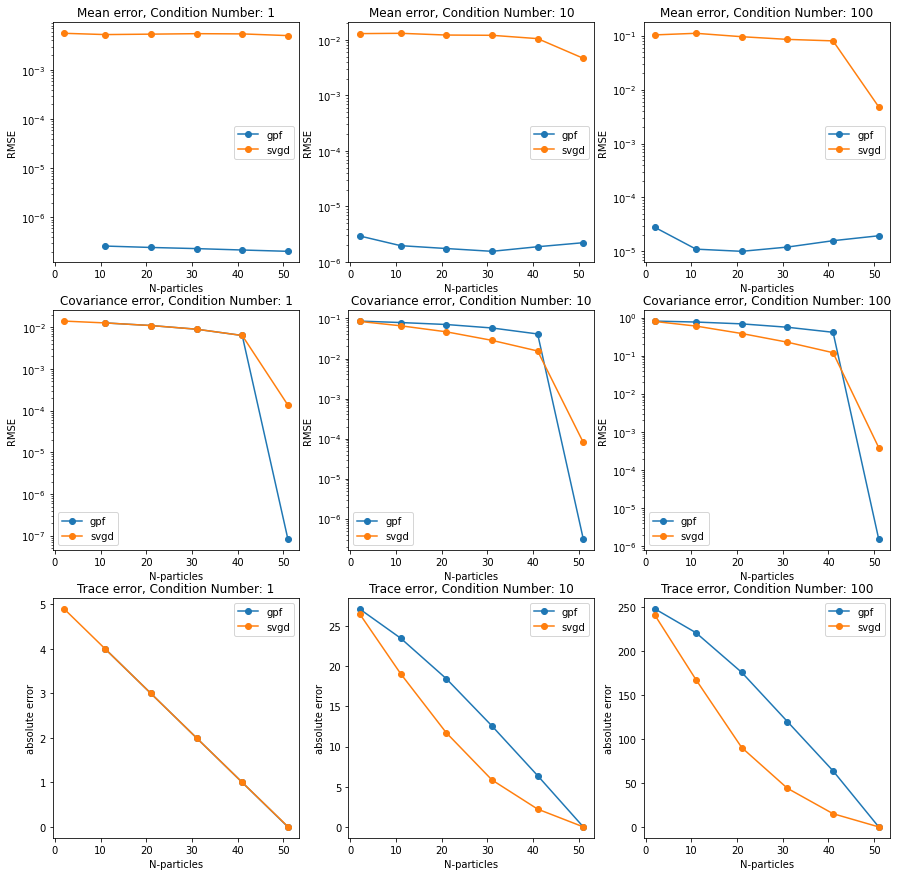

In [22]:
fig,axs = plt.subplots(3,len(Cs),figsize=(15,15))
for i,C in enumerate(Cs):
    plt.sca(axs[0,i])
    for j in range(len(labels)):
        plt.semilogy(Ns,mean_rmse[i,:,j],'-o',label=labels[j])
    plt.legend()
    plt.xlabel('N-particles')
    plt.ylabel('RMSE')
    plt.title('Mean error, Condition Number: {}'.format(C))
    
    plt.sca(axs[1,i])
    for j in range(len(labels)):
        plt.semilogy(Ns,cov_rmse[i,:,j],'-o',label=labels[j])
    plt.legend()
    plt.xlabel('N-particles')
    plt.ylabel('RMSE')
    plt.title('Covariance error, Condition Number: {}'.format(C))
    
    plt.sca(axs[2,i])
    for j in range(len(labels)):
        plt.plot(Ns,cov_tr[i,:,j],'-o',label=labels[j])
    plt.legend()
    plt.xlabel('N-particles')
    plt.ylabel('absolute error')
    plt.title('Trace error, Condition Number: {}'.format(C))

In [30]:
#history based evaluation

mean_rmse = torch.zeros((len(Cs),len(Ns),2,num_iter))
cov_rmse = torch.zeros((len(Cs),len(Ns),2,num_iter))
trace_err = torch.zeros((len(Cs),len(Ns),2,num_iter))
l2step = torch.zeros((len(Cs),len(Ns),2,num_iter-1))

run = 0 #this is the run with the histories included!

for i,C in enumerate(Cs):
    for j,N in enumerate(Ns):
        
        run_path = os.path.join(data_path,'run_{}_C_{}_N_{}'.format(run,C,N))

        p = torch.load(os.path.join(run_path,'target'))
        
        for k,label in enumerate(labels):
            x = torch.load(os.path.join(run_path,'x_{}'.format(label)))
            mean_rmse[i,j,k],cov_rmse[i,j,k],trace_err[i,jk] += my.evaluate(x)

            #calculate the l2 norm of the update step at each step
            l2step[i,j,k] += torch.linalg.norm(x[1:]-x[:-1],dim=(1,2))
            
l2step /= num_runs
trace_err /= num_runs
cov_rmse /= num_runs
mean_rmse /= num_runs

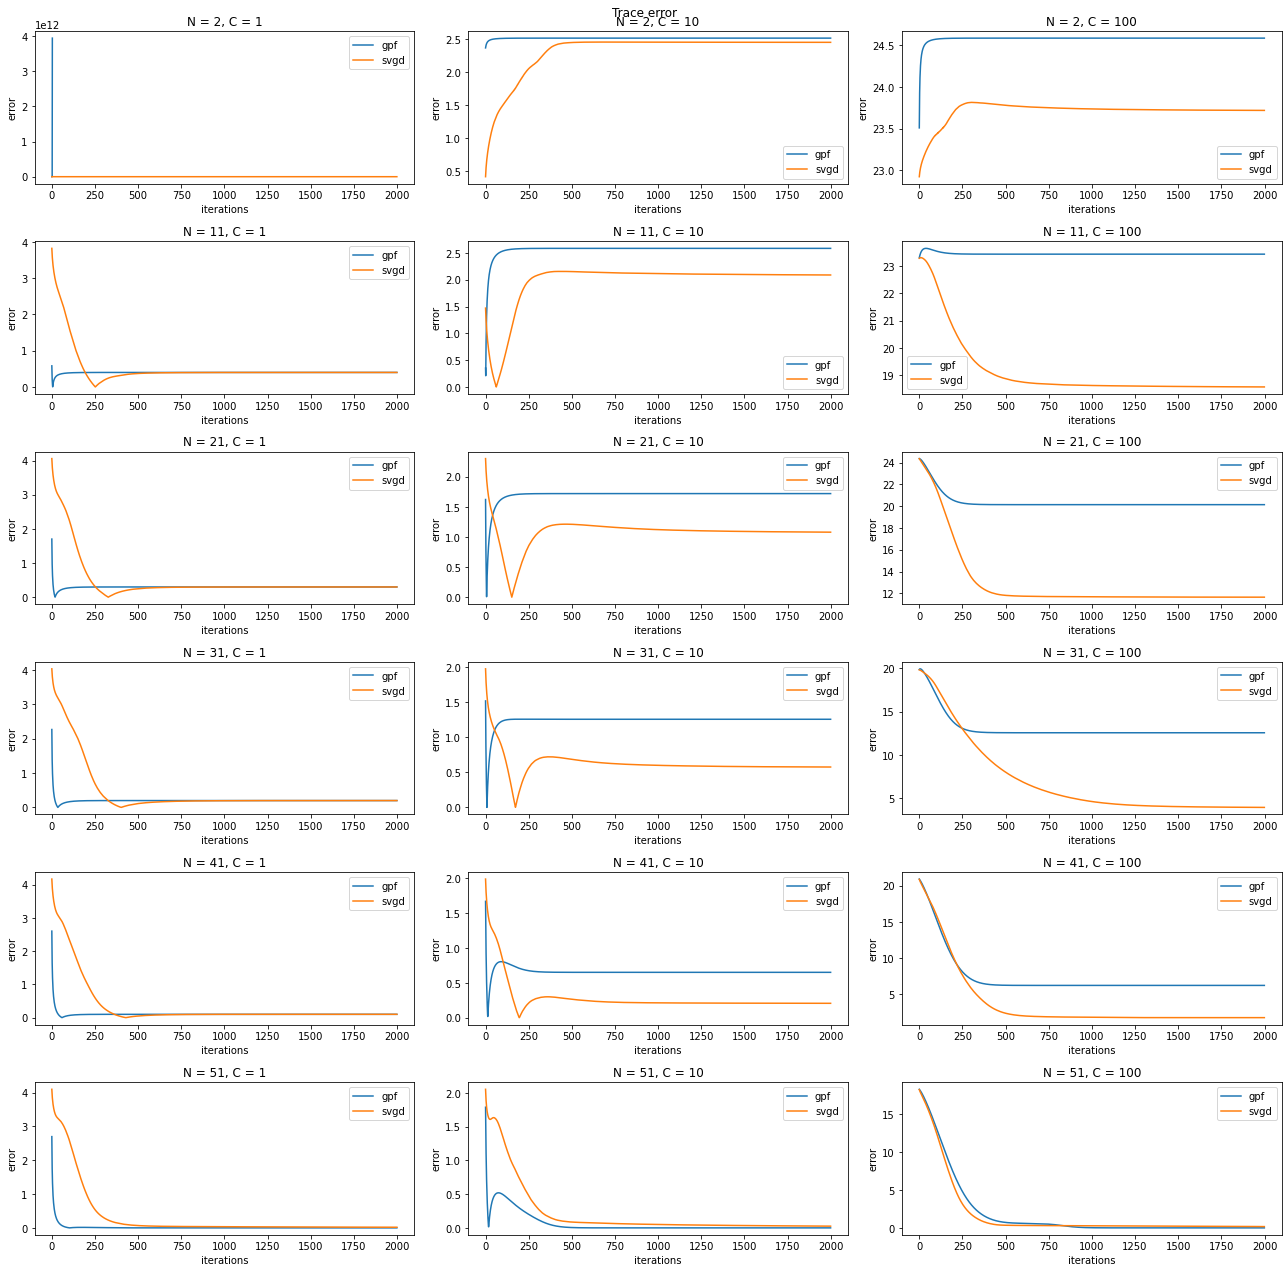

In [39]:
display_iter = 2000

fig,axs = plt.subplots(len(Ns),len(Cs),figsize=(3*len(Ns),6*len(Cs)))
for i,N in enumerate(Ns):
    for j,C in enumerate(Cs):
        plt.sca(axs[i,j])
        for k,label in enumerate(labels):
            plt.plot(np.arange(display_iter),trace_err[j,i,k,:display_iter],label = label)
        plt.title('N = {}, C = {}'.format(N,C))
        plt.ylabel('absolute error')
        plt.xlabel('iterations')
        plt.legend()
plt.suptitle('Trace error')
fig.tight_layout()
plt.show()

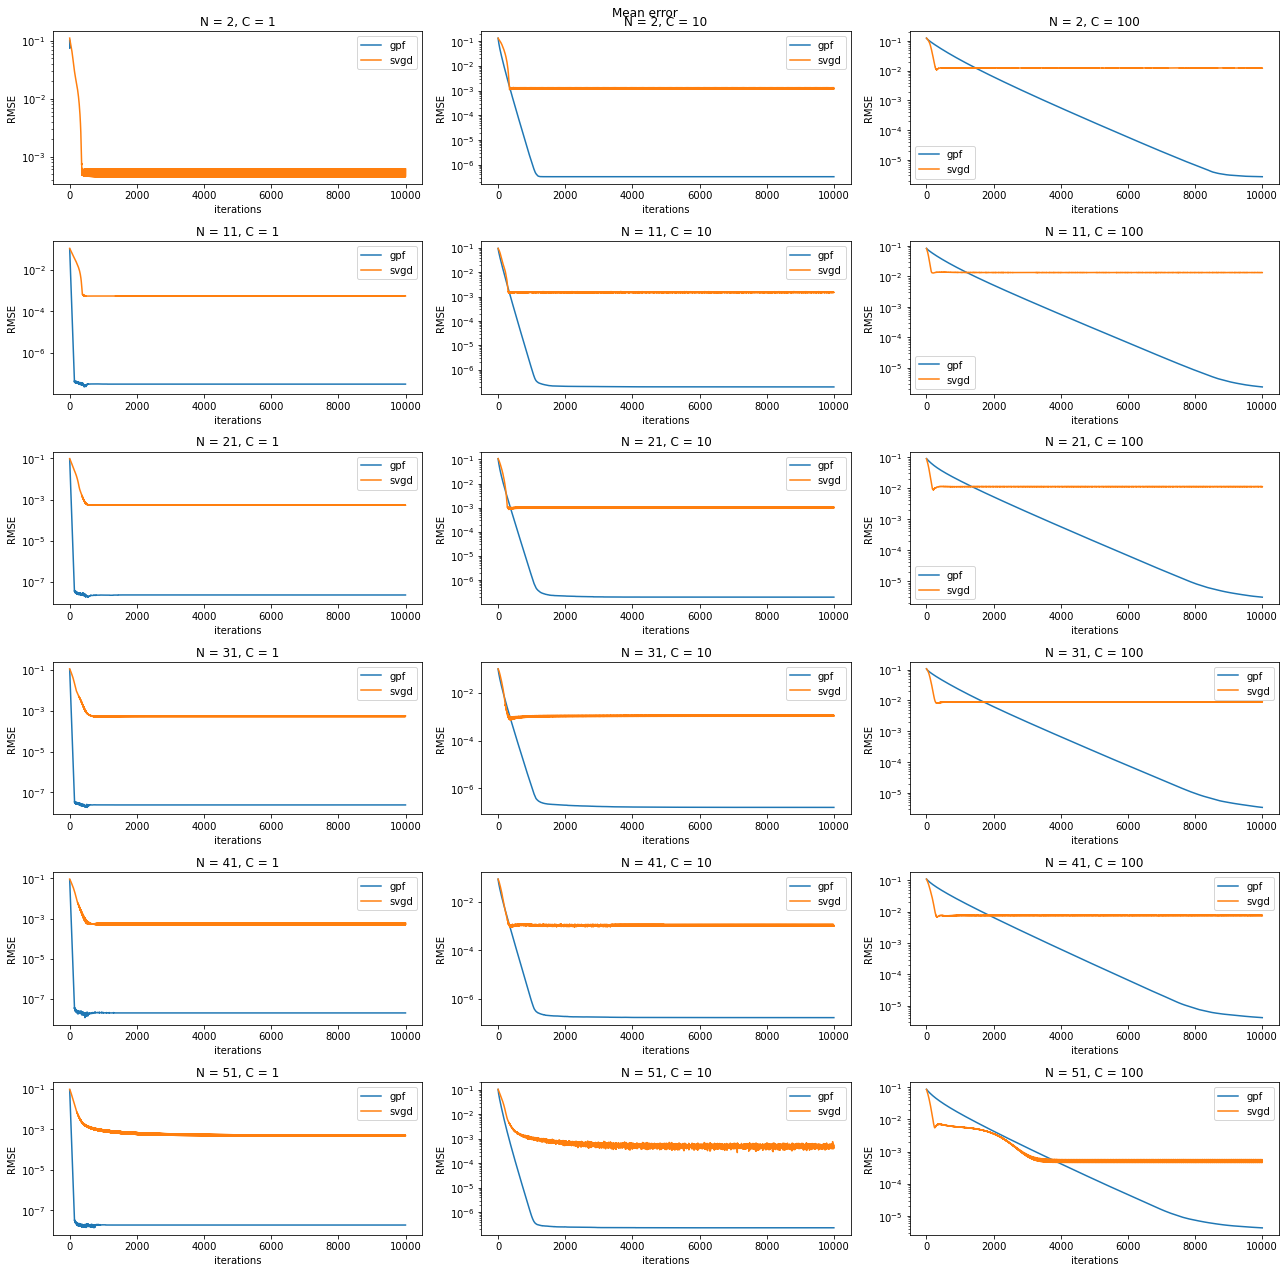

In [49]:
display_iter = 10000

fig,axs = plt.subplots(len(Ns),len(Cs),figsize=(3*len(Ns),6*len(Cs)))
for i,N in enumerate(Ns):
    for j,C in enumerate(Cs):
        plt.sca(axs[i,j])
        for k,label in enumerate(labels):
            plt.semilogy(np.arange(display_iter),mean_rmse[j,i,k,:display_iter],label = label)
        plt.title('N = {}, C = {}'.format(N,C))
        plt.ylabel('RMSE')
        plt.xlabel('iterations')
        plt.legend()
plt.suptitle('Mean error')
fig.tight_layout()
plt.show()

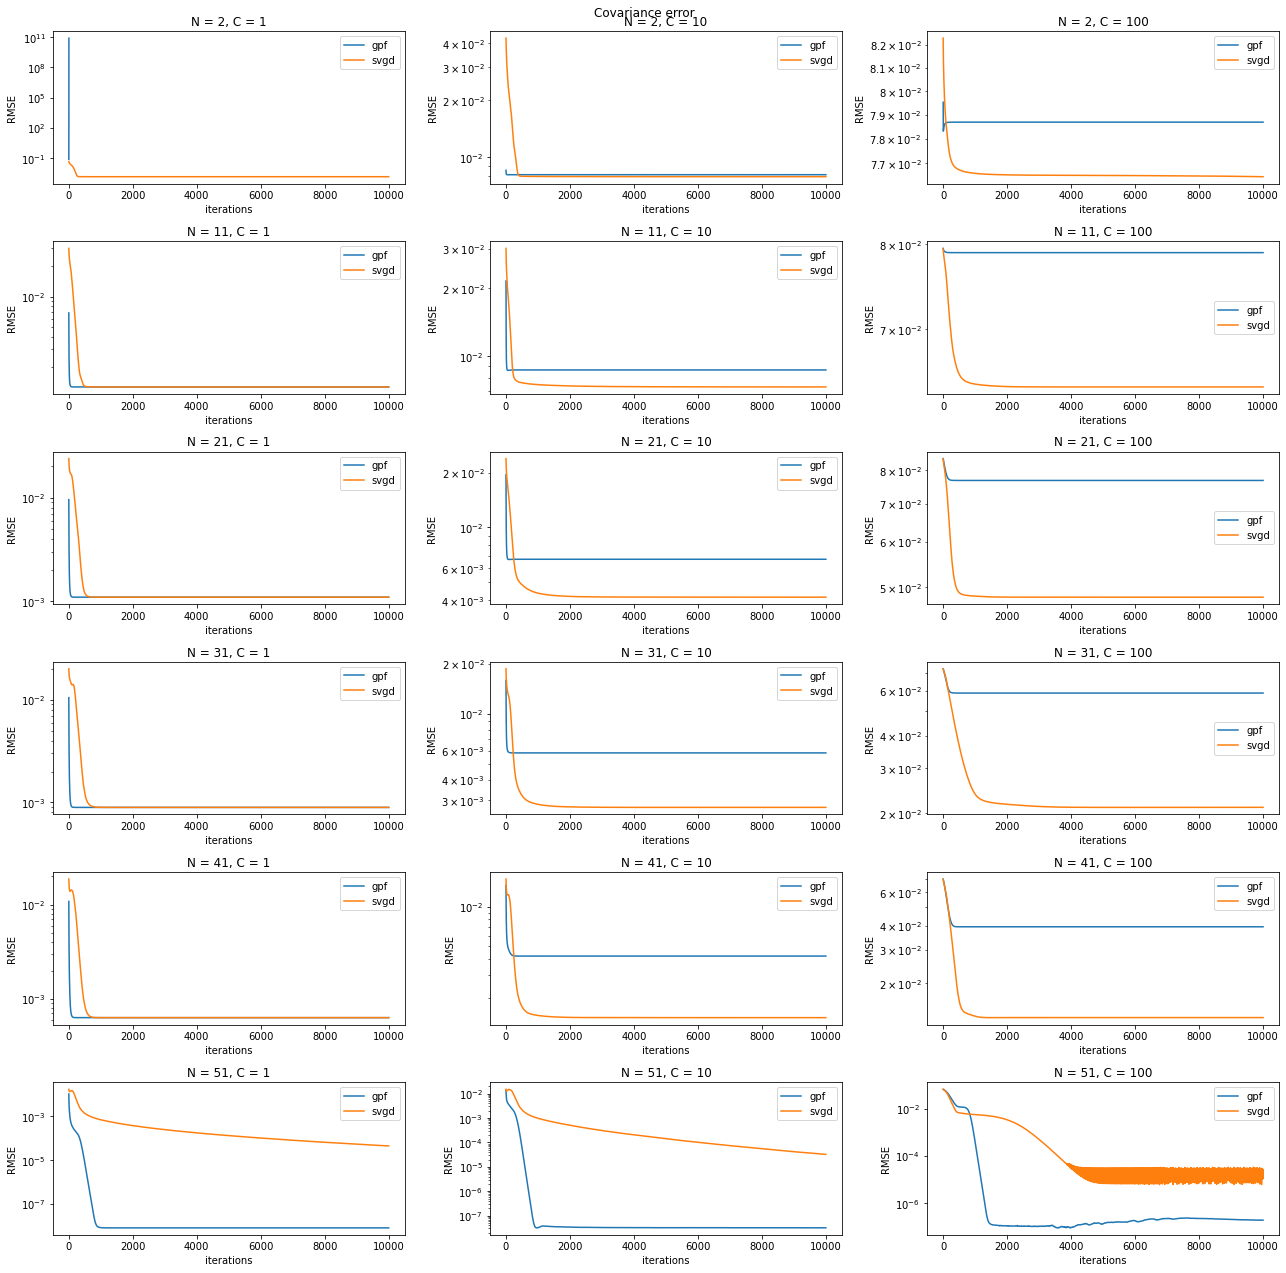

In [48]:
display_iter = 10000

fig,axs = plt.subplots(len(Ns),len(Cs),figsize=(3*len(Ns),6*len(Cs)))
for i,N in enumerate(Ns):
    for j,C in enumerate(Cs):
        plt.sca(axs[i,j])
        for k,label in enumerate(labels):
            plt.semilogy(np.arange(display_iter),cov_rmse[j,i,k,:display_iter],label = label)
        plt.title('N = {}, C = {}'.format(N,C))
        plt.ylabel('RMSE')
        plt.xlabel('iterations')
        plt.legend()
plt.suptitle('Covariance error')
fig.tight_layout()
plt.show()